In [2]:
%autoreload 2

In [3]:
from collections import defaultdict
import copy
import os
import sys
import typing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS


In [4]:
fitness_df = utils.load_fitness_data()
print(fitness_df.columns)
fitness_df.head()

Index(['Index', 'src_file', 'game_name', 'domain_name', 'variables_defined',
       'all_preferences_used', 'setup_objects_used', 'no_adjacent_once',
       'starts_and_ends_once', 'variable_not_repeated', 'no_nested_logicals',
       'pref_forall_correct', 'real', 'original_game_name'],
      dtype='object')


,Index,src_file,game_name,domain_name,variables_defined,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,variable_not_repeated,no_nested_logicals,pref_forall_correct,real,original_game_name
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1.0,1.0,1.00,1.0,0.5,1.0,1.0,1.0,True,6172feb1665491d1efbce164-0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,True,5f77754ba932fb2c4ba181d8-2
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1.0,1.0,0.00,0.0,0.0,1.0,0.0,0.0,True,614b603d4da88384282967a7-3
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1.0,1.0,0.00,1.0,1.0,1.0,1.0,1.0,True,5bc79f652885710001a0e82a-5
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1.0,1.0,0.25,1.0,1.0,1.0,1.0,1.0,True,614dec67f6eb129c3a77defd-6


In [6]:
fitness_df[fitness_df.game_name == '6172feb1665491d1efbce164-0-5']

,Index,src_file,game_name,domain_name,variables_defined,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,variable_not_repeated,no_nested_logicals,pref_forall_correct,real,original_game_name
359,359,ast-regrowth-samples.pddl,6172feb1665491d1efbce164-0-5,medium-objects-room-v1,1.0,1.0,1.0,1.0,0.5,0.786885,1.0,1.0,False,6172feb1665491d1efbce164-0


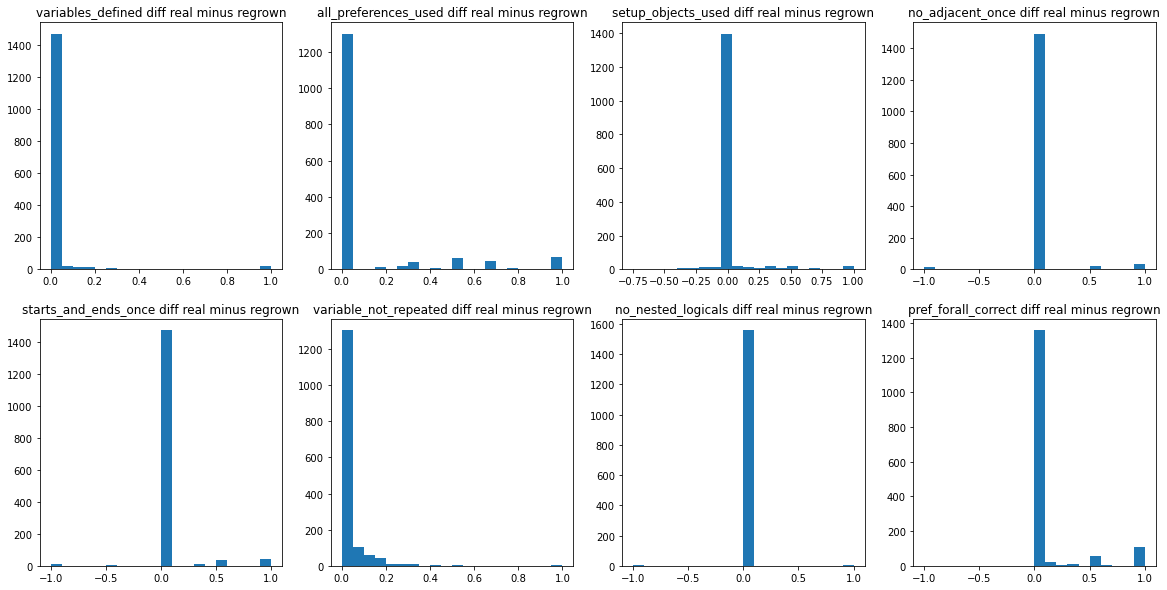

In 50.13% of the games, the regrown game was identical to the original game.


In [4]:
fake_games = fitness_df[fitness_df.src_file == 'ast-regrowth-samples.pddl'].reset_index()
broadcasted_original = fitness_df.loc[[fitness_df.index[(fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
index = 0
for column in original_regrown_diffs.columns:
    if column in ('index', 'Index', 'real'):
        continue

    ax = axes[index // 4][index % 4]
    ax.hist(original_regrown_diffs[column], bins=20)
    ax.set_title(f'{column} diff real minus regrown')
    index += 1

plt.show()
unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

# Approach
* In each batch, sample some number of real games, and for each of them, subsample some number of the corrupted games.
* Learn a regressor to the fitness (maybe with a hidden layer?)
* Try different regularization approaches/strengths (L1, L2, both)
* Evaluate on held-out validation set, see that it doesn't collapse

## Loss function
I'm inspired by the way Chris Dyer (in https://arxiv.org/abs/1410.8251) writes down the NCE loss:
$$ \mathcal{L}_{NCE_k}^{MC} = \sum_{(w,c) \in \mathcal{D}} \left( \log p (D = 1 \mid c, w) - \sum_{i=1, \bar{w} \sim q}^k \log p (D = 0 \mid c, \bar{w}) \right) $$
where: 
* $\mathcal{D}$ is the dataset comprised of pairs $(c, w)$ of context and the correct continuation $w$
* $D$ is the label, where $D = 1$ indicates true data and $D = $ indicates noise
* $q$ is a noise proposal distribution from which to sample $\bar{w}$, the noise foil examples for the current context.

In our case: 
* I think of the context $c$ as some game id, where the correct production $w$ is the true game
* Tha labels $D$ behave as they do above, $D = 1$ for a correct game and $D = 0$ for an incorrect one. 
* Our regrowth sampler is the proposal distribution $q$ (from which we could eventually generate as many samples as we want, but currently I pre-generate some number of samples per game).
* Given that my fitness model produces a single output, which I currently pass through a sigmoid, we can think about it as outputting $P(D = 1 \mid c, w)$, and taking 1 - its output as $P(D = 0 \mid \cdot)$

Thus, the procedure becomes:
1. In each batch, sample some number $B$ of true games.
2. For each of those, sample $k$ correuptions of the game. 
3. Compute the loss for this example, and then average over the minibatch.
4. Take a gradient step in this direction.


# Reworking the above logic to support cross-validation

## Data splitting approach
Under the NCE-style thing I want to try, I basically want to take the real games and split them train/val/test, and then use the regrowth samples corresponding to each game for negative examples and for the normalization.

In [5]:
all_features = [
    'variables_defined',
    'all_preferences_used', 'setup_objects_used', 'no_adjacent_once',
    'starts_and_ends_once', 'variable_not_repeated', 'no_nested_logicals',
    'pref_forall_correct']

def cross_validate(train: pd.DataFrame, feature_columns: typing.List[str], param_grid: typing.Dict[str, typing.Any],
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):
    train_tensor = utils.df_to_tensor(train, feature_columns)
    pipeline = Pipeline(steps=[('scaler', utils.CustomSklearnScaler()), ('fitness', utils.SklearnFitnessWrapper(train_kwargs=train_kwargs))])

    param_grid['fitness__n_features'] = [len(feature_columns)]

    cv = GridSearchCV(pipeline, param_grid, scoring=utils.evaluate_fitness, cv=5, n_jobs=-1, verbose=1)
    cv.fit(train_tensor, None)
    return cv



In [6]:
train_df, test_df = utils.train_test_split_by_game_name(fitness_df)

In [7]:
test_param_grid = {
    'fitness__n_outputs': [1], 
    'fitness__weight_decay': [0.0, 0.01, 0.05, 0.1], 
    'fitness__hidden_size': [None, 2, 4]   
}
cv = cross_validate(train_df, all_features, test_param_grid, train_kwargs=dict(should_print=False))
cv_df = pd.concat([
    pd.DataFrame(cv.cv_results_["params"]), 
    pd.DataFrame(cv.cv_results_["mean_test_score"], columns=['score_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_score"], columns=['score_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_score"], columns=['score_rank']),
],axis=1)

cv_df.sort_values(by='score_rank').head(10)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,fitness__hidden_size,fitness__n_features,fitness__n_outputs,fitness__weight_decay,score_mean,score_std,score_rank
1,NaN,8,1,0.01,0.073656,0.005602,1
0,NaN,8,1,0.00,0.071151,0.008782,2
2,NaN,8,1,0.05,0.068247,0.010311,3
3,NaN,8,1,0.10,0.062703,0.008151,4
9,4.0,8,1,0.01,0.026015,0.033376,5
11,4.0,8,1,0.10,0.019402,0.037478,6
4,2.0,8,1,0.00,0.010163,0.011931,7
10,4.0,8,1,0.05,0.007857,0.016155,8
5,2.0,8,1,0.01,0.005212,0.014007,9
6,2.0,8,1,0.05,0.004115,0.031188,10


In [8]:
train_tensor = utils.df_to_tensor(train_df, all_features)
test_tensor = utils.df_to_tensor(test_df, all_features)

In [9]:
best_model = cv.best_estimator_.named_steps['fitness'].model

In [10]:
train_preds = best_model(train_tensor).detach().numpy()
test_preds = best_model(test_tensor).detach().numpy()
train_preds.shape, test_preds.shape

((78, 17, 1), (20, 17, 1))

In [11]:
from sklearn.metrics import f1_score


def predict_at_threshold(preds: np.ndarray, threshold: float):
    y_pred = (preds > threshold).astype(int)
    y_true = np.zeros_like(y_pred)
    y_true[:, 0] = 1
    return y_true.reshape(-1), y_pred.reshape(-1)


def evaluate_f1_with_threshold(preds: np.ndarray, threshold: float):
    return f1_score(*predict_at_threshold(preds, threshold))


def find_f1_threshold(preds: np.ndarray):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(0, 1, 100):
        f1 = evaluate_f1_with_threshold(preds, threshold)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

train_threshold, train_f1 = find_f1_threshold(train_preds)
train_threshold, train_f1, evaluate_f1_with_threshold(test_preds, train_threshold)

(0.5151515151515152, 0.16554809843400448, 0.1346153846153846)

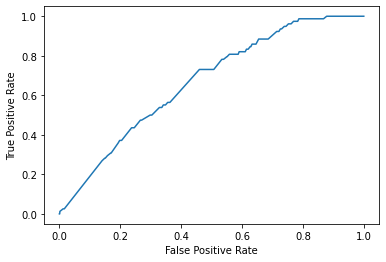

In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay


y_true, y_pred = predict_at_threshold(train_preds, train_threshold)

fpr, tpr, _ = roc_curve(y_true, train_preds.reshape(-1))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


In [ ]:
y_true.shape